<a href="https://colab.research.google.com/github/AFBA1993/Projects/blob/main/TemporalSeries/PAGS/Attemptotal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io

In [38]:
url = ('https://raw.githubusercontent.com/AFBA1993/Projects/main/'+
       'TemporalSeries/PAGS/PAGSattempt.csv')

In [39]:
url_data = requests.get(url).content
data = pd.read_csv(io.StringIO(url_data.decode('utf-8')))

In [40]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1038,2022-03-09,13.01,13.73,13.01,13.44,13.44,2140900
1039,2022-03-10,13.09,13.16,12.61,12.95,12.95,1971400
1040,2022-03-11,13.29,13.65,12.55,12.61,12.61,2065300
1041,2022-03-14,12.40,12.87,11.76,11.90,11.90,1795300
1042,2022-03-15,11.85,12.61,11.85,12.51,12.51,2470450


In [41]:
data = data[["Date","Close"]]

In [42]:
data.index = pd.to_datetime(data["Date"])
data.drop("Date", axis = 1, inplace =  True)

In [43]:
train = data

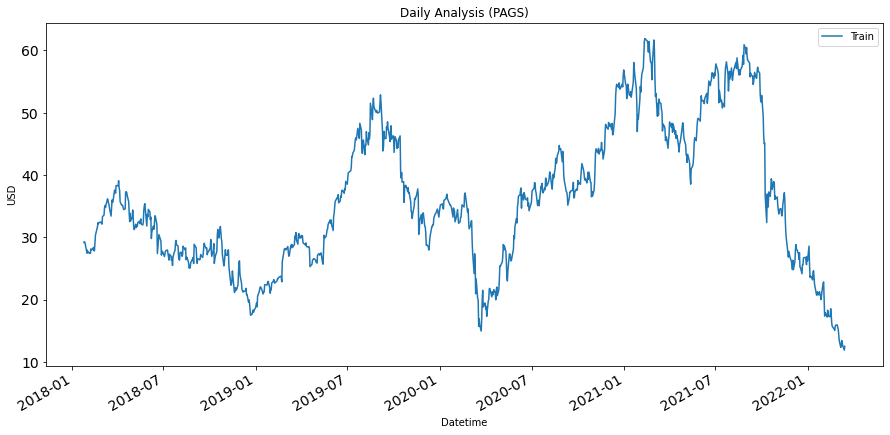

In [44]:
train.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', 
                 fontsize =14, label = 'Train')
plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

In [45]:
normalizer = MinMaxScaler(feature_range = (0,1))
train_norm = normalizer.fit_transform(train)
forecasters_train = []
actual_value_train = []
train.size

1043

In [46]:
for i in range(100, 1043):
  forecasters_train.append(train_norm[i-100:i,0])
  actual_value_train.append(train_norm[i, 0])

In [47]:
forecasters_train , actual_value_train = np.array(forecasters_train), \
                                         np.array(actual_value_train)
print(forecasters_train.shape[0],
      forecasters_train.shape[1])

943 100


In [48]:
forecasters_train = np.reshape(forecasters_train, (943, 100, 1))

In [49]:
regressor = Sequential()
regressor.add(LSTM(units = 150, return_sequences = True,
                   input_shape = (forecasters_train.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))


regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))



regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mse',
                  metrics = ['mse'])


regressor.fit(forecasters_train, actual_value_train, 
                      epochs = 100, batch_size = 32)

Epoch 1/100
30/30 [==============================] - 18s 300ms/step - loss: 0.0585 - mse: 0.0585
Epoch 2/100
30/30 [==============================] - 9s 299ms/step - loss: 0.0216 - mse: 0.0216
Epoch 3/100
30/30 [==============================] - 9s 296ms/step - loss: 0.0226 - mse: 0.0226
Epoch 4/100
30/30 [==============================] - 9s 298ms/step - loss: 0.0171 - mse: 0.0171
Epoch 5/100
30/30 [==============================] - 9s 296ms/step - loss: 0.0156 - mse: 0.0156
Epoch 6/100
30/30 [==============================] - 10s 328ms/step - loss: 0.0149 - mse: 0.0149
Epoch 7/100
30/30 [==============================] - 10s 315ms/step - loss: 0.0117 - mse: 0.0117
Epoch 8/100
30/30 [==============================] - 10s 328ms/step - loss: 0.0130 - mse: 0.0130
Epoch 9/100
30/30 [==============================] - 9s 303ms/step - loss: 0.0101 - mse: 0.0101
Epoch 10/100
30/30 [==============================] - 9s 299ms/step - loss: 0.0097 - mse: 0.0097
Epoch 11/100
30/30 [===============

Predicting Future Values:

In [139]:
modified_train = train

In [144]:
future_days = 365
initial_fut_date = '2022-03-16'

In [145]:
for i in range (future_days):

  rng = pd.date_range(initial_fut_date, periods=1, freq='D')
  new_val = pd.DataFrame({ 'Close' : np.nan }, index=rng)

  total_data = pd.concat((modified_train, new_val), axis = 0)
  input_test = total_data[len(total_data) - len(new_val) - 100:]
  input_test_norm = normalizer.transform(input_test)


  X_test = []
  for i in range(100, input_test.shape[0]):
    X_test.append(input_test_norm[i-100:i,0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

  predicted_val = regressor.predict(X_test)
  predicted_val = normalizer.inverse_transform(predicted_val)
  forecasted_LSTM = pd.DataFrame(predicted_val, columns = ['Close'])
  forecasted_LSTM["Date"] = new_val.index
  forecasted_LSTM.index = pd.to_datetime(forecasted_LSTM["Date"])
  forecasted_LSTM.drop("Date", axis = 1, inplace =  True)

  modified_train = pd.concat((modified_train, forecasted_LSTM), axis = 0)

  update_date = pd.date_range(initial_fut_date, periods=2, freq='D')
  update_date_val = pd.DataFrame({ 'Close' : np.nan }, index=update_date)

  initial_fut_date = str(update_date_val.index[-1])

In [146]:
Future = modified_train.tail(future_days)


---



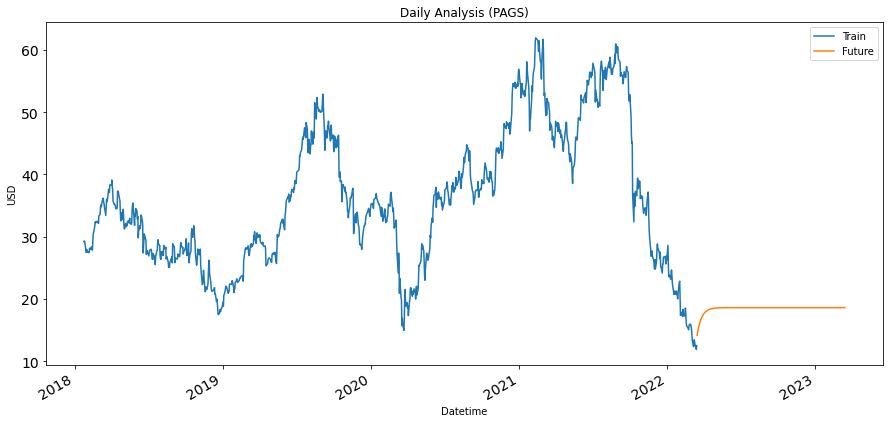

In [148]:
train.Close.plot(figsize = (15,7), label = 'Train')
Future.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', 
                 fontsize =14, label = 'Future')

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')